In [2]:
%matplotlib inline
import numpy as np
import lib.io.stan
import matplotlib.pyplot as plt
import os
from matplotlib import colors, cm, gridspec

Read Gain matrix and fitting target from simulated data

In [2]:
data_dir = 'datasets/id001_ac'
results_dir = 'results/exp10/exp10.1'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/AC_network.npz')
SC = network['SC']
SC = SC / np.max(SC)
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

syn_data = np.load(f'{data_dir}/AC_fit_trgt.npz')

Dump the data to R file and start sampling with HMC

In [4]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = syn_data['fit_trgt'].shape[0]
epsilon = 0.01

stan_fname = 'vep-snsrfit-lin'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

data = {'nn':nn, 'ns':ns, 'nt':nt, 'gain': gain_mat,
        'seeg':syn_data['fit_trgt'], 'epsilon':epsilon}

input_Rfile = f'fit_data_AC_lin.R'
os.makedirs(f'{data_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{data_dir}/Rfiles/{input_Rfile}',data)

nchains = 8
with open('vep-snsrfit-lin.sh','r') as fd:
    slurm_script = fd.read().format(f'{data_dir}/Rfiles', results_dir, input_Rfile, nchains, epsilon)
with open(f'tmp/vep-snsrfit-lin-eps{epsilon:0.5f}.sh','w') as fd:
    fd.write(slurm_script)
lib.io.stan.create_process(['sbatch',f'tmp/vep-snsrfit-lin-eps{epsilon:0.5f}.sh'],block=False)


/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/vep-snsrfit-lin' is up to date.


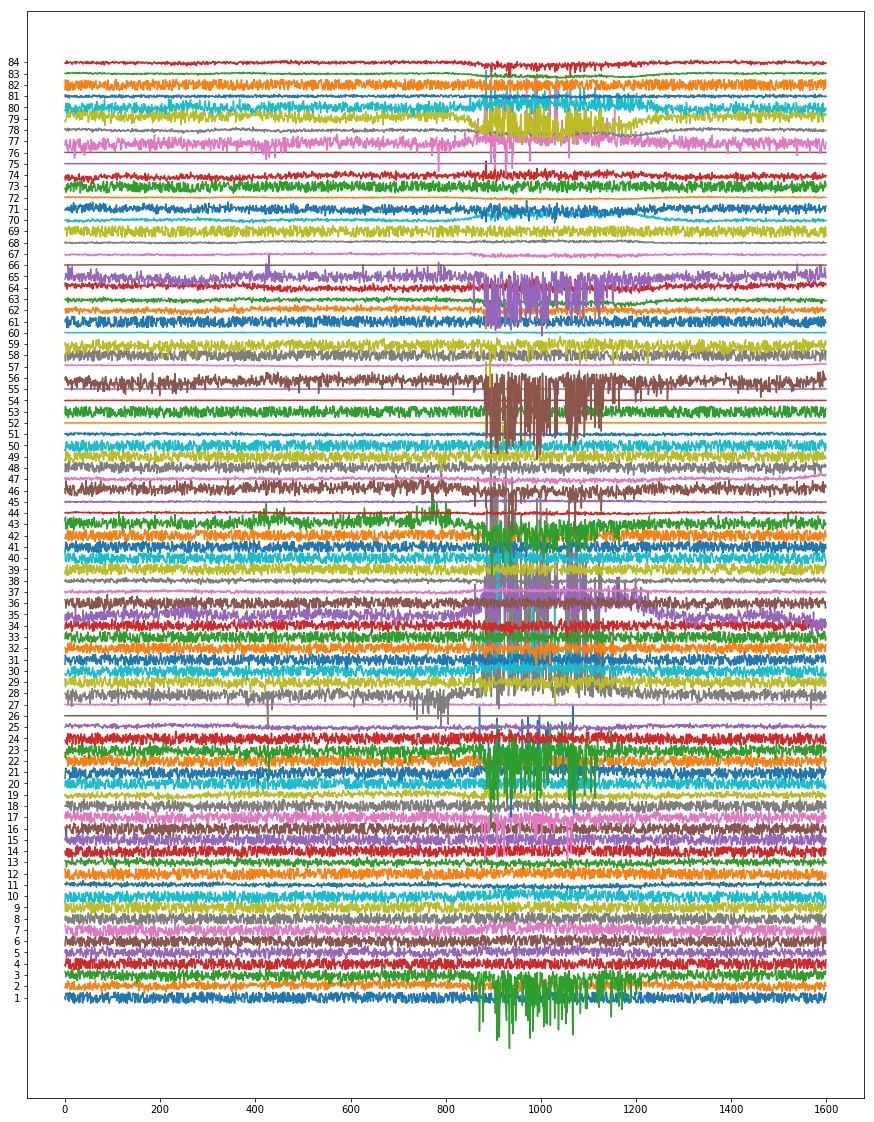

In [3]:
csv_fname = 'results/exp10/exp10.1/samples_eps0.01000_chain2.csv'
nwarmup = 500
nsampling = 500
ignore_warmup = True
hmc_samples = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup)

plt.figure(figsize=[15,20])
plt.plot(hmc_samples['x'][-1,:,:]/4.0 + np.r_[0:84]);
plt.yticks(np.r_[0:84], np.r_[1:85]);